/home/bio/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizing SMILES...
✅ Saved new best model at epoch 1 with ROC-AUC: 0.7652
Epoch 1: Loss=0.5123, Train Acc=0.7523, Test Acc=0.8063, ROC-AUC=0.7652
Confusion Matrix:
[[334 211]
 [ 78 869]]
Classification Report:
              precision    recall  f1-score   support

    inactive       0.81      0.61      0.70       545
      active       0.80      0.92      0.86       947

    accuracy                           0.81      1492
   macro avg       0.81      0.77      0.78      1492
weighted avg       0.81      0.81      0.80      1492

Mean Gate (first 10 dims): [0.49076873 0.46154428 0.46758702 0.45126376 0.48134086 0.5015968
 0.5361548  0.47426826 0.6444188  0.45166573]
✅ Saved new best model at epoch 2 with ROC-AUC: 0.7826
Epoch 2: Loss=0.4138, Train Acc=0.8183, Test Acc=0.8130, ROC-AUC=0.7826
Confusion Matrix:
[[365 180]
 [ 99 848]]
Classification Report:
              precision    recall  f1-score   support

    inactive       0.79      0.67      0.72       545
      active       0.8

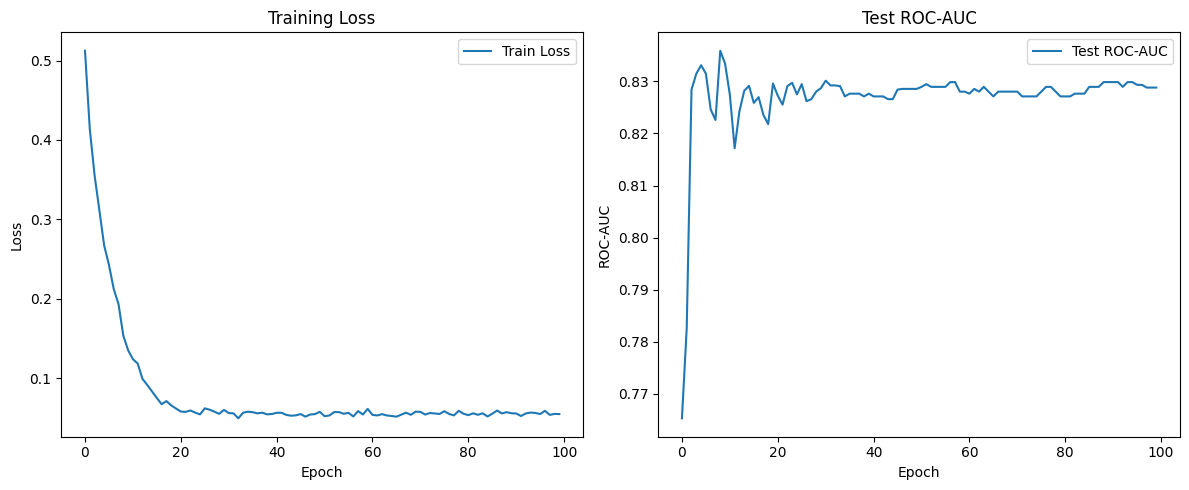

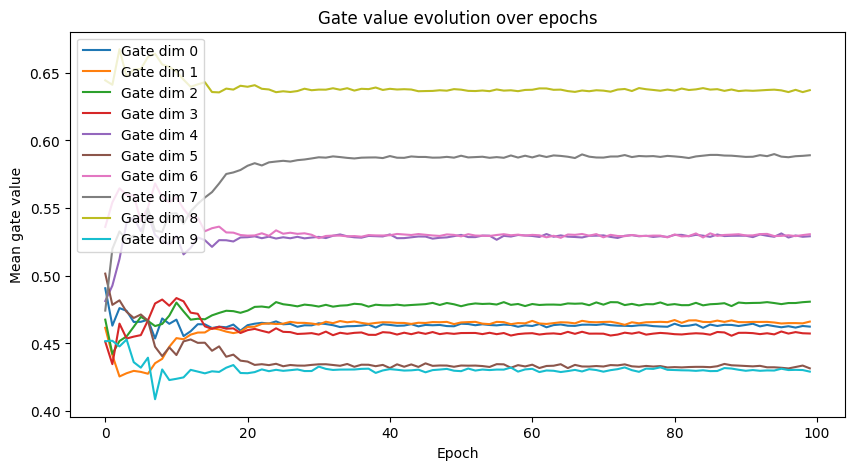

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from transformers import AutoTokenizer, AutoModel
from rdkit import Chem
from rdkit.Chem import rdmolops
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# ======== Load dataset ========
file_path = 'bace1_bioactivity_data_curated.csv'
df = pd.read_csv(file_path)
df['class'] = df['class'].apply(lambda x: 1 if x == 'active' else 0)

# ======== Initialize tokenizer & model ========
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
chembert_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# ======== Precompute tokenized inputs ========
print("Tokenizing SMILES...")
def tokenize_smiles(smi):
    tokens = tokenizer(smi, truncation=True, padding='max_length', max_length=128, return_tensors="pt")
    return {
        'input_ids': tokens['input_ids'].squeeze(0),
        'attention_mask': tokens['attention_mask'].squeeze(0)
    }

df['tokens'] = df['canonical_smiles'].apply(tokenize_smiles)

# ======== Convert to PyG Data ========
def get_atom_features(mol):
    feats = []
    for atom in mol.GetAtoms():
        feats.append([
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            atom.GetHybridization(),
            int(atom.GetIsAromatic())
        ])
    return torch.tensor(feats, dtype=torch.float)

def mol_to_data(row):
    smiles = row['canonical_smiles']
    label = torch.tensor(row['class'], dtype=torch.long)
    tokens = row['tokens']

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    x = get_atom_features(mol)
    adj = rdmolops.GetAdjacencyMatrix(mol)
    edge_index = torch.tensor(np.array(adj.nonzero()), dtype=torch.long)

    data = Data(x=x, edge_index=edge_index, y=label)
    data.input_ids = tokens['input_ids']
    data.attention_mask = tokens['attention_mask']
    return data

dataset = [mol_to_data(row) for _, row in df.iterrows()]
dataset = [d for d in dataset if d is not None]

# ======== Split ========
train_data, test_data = train_test_split(dataset, test_size=0.2, stratify=df['class'], random_state=42)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

# ======== Model ========
class HybridModel(nn.Module):
    def __init__(self, chembert, gnn_in=5, gnn_hidden=64, bert_hidden=768, out_dim=2):
        super().__init__()
        self.conv1 = GCNConv(gnn_in, gnn_hidden)
        self.conv2 = GCNConv(gnn_hidden, gnn_hidden)

        self.chembert = chembert

        self.vector_gate = nn.Sequential(
            nn.Linear(gnn_hidden + bert_hidden, gnn_hidden + bert_hidden),
            nn.Sigmoid()
        )

        self.linear1 = nn.Linear(gnn_hidden + bert_hidden, 128)
        self.linear2 = nn.Linear(128, out_dim)

    def forward(self, data):
        # GNN
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)

        # ChemBERT
        input_ids = torch.stack([d.input_ids for d in data.to_data_list()]).to(x.device)
        attention_mask = torch.stack([d.attention_mask for d in data.to_data_list()]).to(x.device)
        
        chem_out = self.chembert(input_ids=input_ids, attention_mask=attention_mask)
        chembert_out = chem_out.last_hidden_state[:, 0, :]  # CLS token

        # Fusion
        combined = torch.cat([x, chembert_out], dim=1)
        gate = self.vector_gate(combined)
        gated = combined * gate

        out = F.relu(self.linear1(gated))
        out = self.linear2(out)

        self.last_gate = gate.detach().cpu()
        return out

# ======== Setup ========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridModel(chembert_model).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
criterion = nn.CrossEntropyLoss()

# ======== Train / eval ========
def train():
    model.train()
    total_loss, correct = 0, 0
    gates = []
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        gates.append(model.last_gate)

    acc = correct / len(train_loader.dataset)
    avg_gate = torch.cat(gates).mean(dim=0).numpy()
    return total_loss / len(train_loader), acc, avg_gate

def evaluate(loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            preds.extend(pred.cpu().numpy())
            labels.extend(data.y.cpu().numpy())

    acc = accuracy_score(labels, preds)
    cm = confusion_matrix(labels, preds)
    roc = roc_auc_score(labels, preds)
    report = classification_report(labels, preds, target_names=['inactive', 'active'])
    return acc, cm, roc, report, preds, labels

# ======== Train loop ========
epochs = 100
all_gates = []
losses = []
rocs = []
best_roc = 0

for epoch in range(epochs):
    loss, train_acc, avg_gate = train()
    test_acc, cm, roc, report, preds, labels = evaluate(test_loader)
    scheduler.step(roc)
    
    losses.append(loss)
    rocs.append(roc)
    all_gates.append(avg_gate)

    # Save best model
    if roc > best_roc:
        best_roc = roc
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"✅ Saved new best model at epoch {epoch+1} with ROC-AUC: {roc:.4f}")

    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}, ROC-AUC={roc:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Classification Report:\n{report}")
    print(f"Mean Gate (first 10 dims): {avg_gate[:10]}")

# ======== Plot loss and ROC-AUC ========
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rocs, label='Test ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('Test ROC-AUC')
plt.legend()

plt.tight_layout()
plt.show()

# ======== Plot gate evolution ========
all_gates = np.array(all_gates)
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.plot(all_gates[:, i], label=f'Gate dim {i}')
plt.xlabel('Epoch')
plt.ylabel('Mean gate value')
plt.title('Gate value evolution over epochs')
plt.legend()
plt.show()


In [10]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()


HybridModel(
  (conv1): GCNConv(5, 64)
  (conv2): GCNConv(64, 64)
  (chembert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(767, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=